## Problem 3 

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import re
import math

dataset = pd.read_csv('train.csv')


# Feature that tells whether a passenger had a cabin on the Titanic
dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
dataset['IsAlone'] = 0
dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

# Remove all NULLS in the Age column
age_avg = dataset['Age'].mean()
age_std = dataset['Age'].std()
age_null_count = dataset['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
# Next line has been improved to avoid warning
dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
dataset['Age'] = dataset['Age'].astype(int)
    
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    

# Mapping Sex
dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Mapping titles
title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
dataset['Title'] = dataset['Title'].map(title_mapping)
dataset['Title'] = dataset['Title'].fillna(0)

# Mapping Embarked
dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# Mapping Fare
dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
dataset['Fare'] = dataset['Fare'].astype(int)

# Mapping Age
dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
dataset.loc[ dataset['Age'] > 64, 'Age'] ;
    
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
dataset = dataset.drop(drop_elements, axis = 1) 

In [2]:
print(len(dataset))
print(len(dataset.loc[dataset["Survived"]==1]))
dataset.head(3)

891
342


,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


In [3]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [4]:
def calc_entropy(column):
    counts = np.bincount(column)
    probs = counts / len(column)
    entropy = 0
    for prob in probs:
        if prob>0:
            entropy += prob * math.log(prob,2)
    return -entropy

In [5]:
#Gini and info gain of starting node
gini_starting = get_gini_impurity(342,891)
print("Gini Starting Node:",gini_starting)

info_starting = calc_entropy(dataset["Survived"])
print("Info gain starting node:",info_starting)
print()
#gini and info gain of sex
gini_men = get_gini_impurity(109, 577)
print("Gini Men Node:",gini_men)
gini_women = get_gini_impurity(233,314)
print("Gini Women Node:",gini_women)

men_weight = 577/891
women_weight = 314/891
weighted_gini_sex_split = (gini_men * men_weight) + (gini_women * women_weight)

sex_gini_decrease = weighted_gini_sex_split - gini_starting
print("Gini Sex Decrease:",sex_gini_decrease)

info_sex = calc_entropy(dataset["Sex"])
print("Info gain sex node:",info_sex)

info_sex_decrease = info_sex-info_starting
print("Info gain sex dcrease:", info_sex_decrease)
print()

#gini and info gain by title
gini_title_1 = get_gini_impurity(81,517)
print("Gini Title 1 Node:",gini_title_1)
gini_title_others = get_gini_impurity(261,374)
print("Gini Title Others Node:",gini_title_others)

title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_title_split = (gini_title_1 * title_1_weight) + (gini_title_others * title_others_weight)

title_gini_decrease = weighted_gini_title_split - gini_starting
print("Gini Title Decrease:",title_gini_decrease)


info_title_1 = calc_entropy(dataset["Title"])
print("Info gain title node:",info_title_1)

info_title_decrease = info_title_1-info_starting
print("Info gain title decrease:",info_title_decrease)

Gini Starting Node: 0.47301295786144265
Info gain starting node: 0.9607079018756469

Gini Men Node: 0.3064437162277843
Gini Women Node: 0.3828350034484158
Gini Sex Decrease: -0.13964795747285214
Info gain sex node: 0.9362046432498521
Info gain sex dcrease: -0.024503258625794833

Gini Title 1 Node: 0.26425329886377663
Gini Title Others Node: 0.42170207898424317
Gini Title Decrease: -0.14267004758907514
Info gain title node: 1.6627939980717152
Info gain title decrease: 0.7020860961960683


In [6]:
class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class MyDecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None
        for idx in range(self.n_features_):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [7]:
cv = KFold(n_splits=10)
accuracies = []
max_attributes=len(list(dataset))
depth_range= range(1, max_attributes+1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = MyDecisionTreeClassifier(max_depth=depth)
    for train_fold, valid_fold in cv.split(dataset):
        f_train = dataset.loc[train_fold]
        f_valid = dataset.loc[valid_fold]
        
        model = tree_model.fit(X=f_train.drop(["Survived"],axis=1),y=f_train["Survived"])
        y_pred = tree_model.predict(f_valid.drop(["Survived"],axis=1))
        valid_acc = accuracy_score(f_valid["Survived"], y_pred)
        fold_accuracy.append(valid_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df=df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.819288
         5          0.823795
         6          0.804782
         7          0.802472
         8          0.804782
         9          0.811523
        10          0.807041
        11          0.801436


In [8]:
X=dataset.drop(['Survived'], axis=1).values
y=dataset['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

decision_tree = MyDecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
acc_decision_tree = accuracy_score(y_pred,y_test)
print(acc_decision_tree)

0.8169491525423729


## Problem 4 

0.8305084745762712


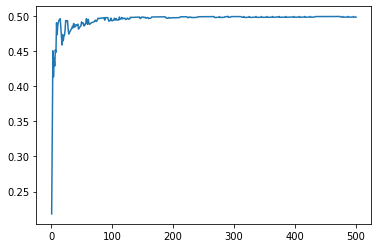

In [47]:
from sklearn.tree import DecisionTreeClassifier

class AdaBoost:
    
    def __init__(self):
        self.stumps =None
        self.stump_weights = None
        self.errors = None
        self.sample_weights = None
        
    def fit(self, X, y, iters):
        n = X.shape[0]

        # init numpy arrays
        self.sample_weights = np.zeros(shape=(iters, n))
        self.stumps = np.zeros(shape=iters, dtype=object)
        self.stump_weights = np.zeros(shape=iters)
        self.errors = np.zeros(shape=iters)

        # initialize weights uniformly
        self.sample_weights[0] = np.ones(shape=n) / n

        for t in range(iters):
            # fit  weak learner
            curr_sample_weights = self.sample_weights[t]
            stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
            stump = stump.fit(X, y, sample_weight=curr_sample_weights)

            # calculate error and stump weight from weak learner prediction
            stump_pred = stump.predict(X)
            err = curr_sample_weights[(stump_pred != y)].sum()# / n
            stump_weight = np.log((1 - err) / err) / 2

            # update sample weights
            new_sample_weights = (
                curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
            )

            new_sample_weights /= new_sample_weights.sum()

            # If not final iteration, update sample weights for t+1
            if t+1 < iters:
                self.sample_weights[t+1] = new_sample_weights

            # save results of iteration
            self.stumps[t] = stump
            self.stump_weights[t] = stump_weight
            self.errors[t] = err

        return self
    
    
    def predict(self, X):
        stump_preds = np.array([stump.predict(X) for stump in self.stumps])
        return np.sign(np.dot(self.stump_weights, stump_preds))
    
X=dataset.drop(['Survived'], axis=1).values
y=dataset['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = AdaBoost().fit(X_train,y_train,iters=500)
y_pred = model.predict(X_test)
print(accuracy_score(y_pred,y_test))

plt.plot([i for i in range(1,501)],model.errors)
plt.show()

## Problem 5

In [92]:
import pickle, gzip
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
f.close()


def to_one_hot(y, num_class=10):
    y_vec = np.zeros((y.shape[0],10))
    for i in range(len(y)):
        y_vec[i][y[i]] = 1
    return y_vec


X_train = train_set[0]
y_train = to_one_hot(train_set[1])
print(X_train.shape)
print(y_train.shape)
X_val = valid_set[0]
y_val = to_one_hot(valid_set[1])
print(X_val.shape)
print(y_val.shape)
X_test = test_set[0]
y_test = to_one_hot(test_set[1])

(50000, 784)
(50000, 10)
(10000, 784)
(10000, 10)


In [135]:
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(784,)))
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_61 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_62 (Dense)             (None, 10)                5010      
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


In [136]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(learning_rate=0.0001),metrics=['accuracy'])

In [137]:
es = EarlyStopping(monitor='val_loss', mode='auto', patience=5)
history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_val,y_val), callbacks=[es])

Epoch 1/50
391/391 [==============================] - 2s 5ms/step - loss: 0.9778 - accuracy: 0.7676 - val_loss: 0.2595 - val_accuracy: 0.9291
Epoch 2/50
391/391 [==============================] - 2s 4ms/step - loss: 0.2499 - accuracy: 0.9298 - val_loss: 0.1884 - val_accuracy: 0.9487
Epoch 3/50
391/391 [==============================] - 1s 4ms/step - loss: 0.1892 - accuracy: 0.9466 - val_loss: 0.1576 - val_accuracy: 0.9562
Epoch 4/50
391/391 [==============================] - 2s 4ms/step - loss: 0.1483 - accuracy: 0.9569 - val_loss: 0.1346 - val_accuracy: 0.9619
Epoch 5/50
391/391 [==============================] - 2s 4ms/step - loss: 0.1237 - accuracy: 0.9650 - val_loss: 0.1192 - val_accuracy: 0.9654
Epoch 6/50
391/391 [==============================] - 2s 4ms/step - loss: 0.1015 - accuracy: 0.9718 - val_loss: 0.1122 - val_accuracy: 0.9688
Epoch 7/50
391/391 [==============================] - 2s 4ms/step - loss: 0.0900 - accuracy: 0.9744 - val_loss: 0.1009 - val_accuracy: 0.9718
Epoch 

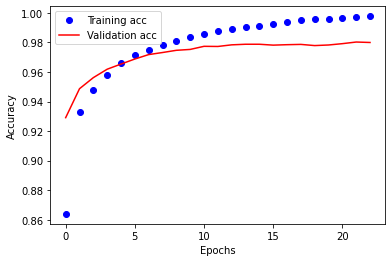

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [141]:
loss_and_acc = model.evaluate(X_test, y_test)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 0s 911us/step - loss: 0.0678 - accuracy: 0.9807
loss = 0.06783760339021683
accuracy = 0.9807000160217285
